# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import time
import numpy as np
import torch

from collections import deque
import matplotlib.pyplot as plt

from ddpg_agent import DDPG_AGENT

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

Number of agents: 2
Size of each action: 2


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [4]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```


In [4]:
agent = DDPG_AGENT(state_size, action_size, 0)



	==== HYPERPARAMETERS USED: ====
	BUFFER_SIZE: 1000000
	BATCH_SIZE: 256
	GAMMA: 0.99
	TAU: 0.2
	LR_ACTOR: 0.0001
	LR_CRITIC: 0.001
	WEIGHT_DECAY: 0




In [6]:
def train_agent(n_episodes=2000, max_t=2000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        
        # Reset Env and Agent
        env_info = env.reset(train_mode=True)[brain_name]  
        states = env_info.vector_observations                   
        episode_scores = np.zeros(num_agents)                           
        agent.reset()
                
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            
            dones = env_info.local_done                        


            # Add experiences to replay buffer
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) 
            
            episode_scores += env_info.rewards                          
            states = next_states                                 
           
            
            if np.any(dones):                                  
                break
     
         # Find Maximum score of both agents and add to array
        scores_deque.append(np.max(episode_scores))
        scores.append(np.max(episode_scores))
        
        if i_episode % print_every == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        
        if np.mean(scores_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return scores

Episode 10	Average Score: 0.02
Episode 20	Average Score: 0.02
Episode 30	Average Score: 0.02
Episode 40	Average Score: 0.01
Episode 50	Average Score: 0.03
Episode 60	Average Score: 0.03
Episode 70	Average Score: 0.04
Episode 80	Average Score: 0.04
Episode 90	Average Score: 0.05
Episode 100	Average Score: 0.05
Episode 110	Average Score: 0.06
Episode 120	Average Score: 0.06
Episode 130	Average Score: 0.06
Episode 140	Average Score: 0.07
Episode 150	Average Score: 0.08
Episode 160	Average Score: 0.09
Episode 170	Average Score: 0.10
Episode 180	Average Score: 0.10
Episode 190	Average Score: 0.11
Episode 200	Average Score: 0.11
Episode 210	Average Score: 0.12
Episode 220	Average Score: 0.12
Episode 230	Average Score: 0.13
Episode 240	Average Score: 0.15
Episode 250	Average Score: 0.15
Episode 260	Average Score: 0.15
Episode 270	Average Score: 0.16
Episode 280	Average Score: 0.16
Episode 290	Average Score: 0.16
Episode 300	Average Score: 0.18
Episode 310	Average Score: 0.19
Episode 320	Avera

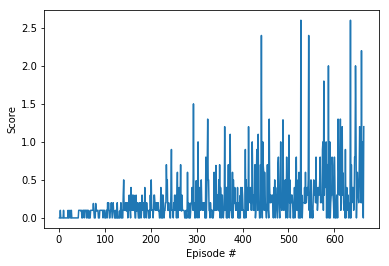

In [7]:
scores = train_agent()

# Plot scores over episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('images/ddpg_scores.png', bbox_inches='tight')
plt.show()

### 5.Watch trained agent!

In [ ]:
# Load the saved weights into Pytorch model
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

for i in range(100):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states)                        # select actions from loaded model agent
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.09500000160187483


When finished, you can close the environment.

In [ ]:
env.close()